# Scratch notebook for debugging and misc calculations

In [2]:
import glob
import json
import networkx as nx
import numpy as np
import qiskit
import pickle
import matplotlib.pyplot as plt

import qcopt

from qiskit import qpy

from qiskit_ibm_runtime import QiskitRuntimeService, Options
from qiskit_ibm_runtime.options import TranspilationOptions, SimulatorOptions

import remote_runtime, runtime_helpers, my_noise_models

from circuit_knitting_toolbox.circuit_cutting.wire_cutting import verify, wire_cutting

## Why is `max_cuts=1` using 3 cuts?

In [2]:
service = QiskitRuntimeService(channel="ibm_cloud")
print(service.backends())
print(service.programs())

[<IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_statevector')>]
[<RuntimeProgram('hello-world-89yvgl6jG5')>, <RuntimeProgram('hello-world')>, <RuntimeProgram('sampler')>, <RuntimeProgram('estimator')>]


In [2]:
# Load data
cur_metric = 'chi2'
shot_metric_data = {}
for cutval in [1,2,3]:
    shot_metric_data[cutval] = []
    for shotval in [100, 200, 400, 800, 1200, 2000, 4000]:
        cur_shot_data = []
        jsonfiles = glob.glob(f'runtime_results/ideal_shot_varying_simulations/*{cutval}-cuts_{shotval}-shots*.json')
        for jf in jsonfiles:
            with open(jf, 'r') as my_json_file:
                data = json.load(my_json_file)
            cur_shot_data.append(data['metrics']['nearest'][cur_metric])
        
        # Loaded all trials at this shot value, now average
        mean_val = np.mean(cur_shot_data)
        stdv_val = np.std(cur_shot_data)
        #mean_val = cur_shot_data[3]
        
        shot_metric_data[cutval].append((shotval, mean_val, stdv_val))

shot_metric_data

{1: [(100, 0.8173663328891021, 0.19758180966743372),
  (200, 0.5288925009793277, 0.1111620909592775),
  (400, 0.3731833311083537, 0.1010450368963029),
  (800, 0.2592336384735349, 0.07706286022912605),
  (1200, 0.21508669338548617, 0.05725266817345057),
  (2000, 0.1706655377836664, 0.05815326725390767),
  (4000, 0.1307430568422045, 0.039790705317998935)],
 2: [(100, 0.26702580247930435, 0.04522315435598229),
  (200, 0.14568692395218993, 0.037201593844820746),
  (400, 0.09397934617194367, 0.022181688153794548),
  (800, 0.047863457076889084, 0.011576647803343774),
  (1200, 0.03673482067332475, 0.008865774531896143),
  (2000, 0.023105897446543542, 0.005125126278708172),
  (4000, 0.012436844685072643, 0.002225575555372902)],
 3: [(100, 1.1178161968552662, 0.25829983452125505),
  (200, 0.9186488493255672, 0.26275713440310916),
  (400, 0.571294574964094, 0.1940073939571185),
  (800, 0.361814279300135, 0.09966293867091602),
  (1200, 0.2691237115652502, 0.06270961676220234),
  (2000, 0.21429994

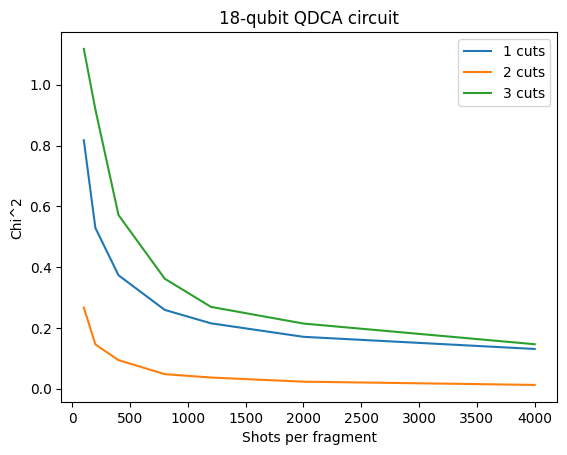

In [3]:
fig, ax = plt.subplots()

for ncuts in [1,2,3]:
    cut_data = shot_metric_data[ncuts]
    x_vals = [t[0] for t in cut_data]
    y_vals = [t[1] for t in cut_data]
    std_vals = [t[2] for t in cut_data]
    upper_bound = [mean + std_dev for mean, std_dev in zip(y_vals, std_vals)]
    lower_bound = [mean - std_dev for mean, std_dev in zip(y_vals, std_vals)]
    ax.errorbar(x_vals, y_vals, label=f'{ncuts} cuts')

ax.set_ylabel('Chi^2')
ax.set_xlabel('Shots per fragment')
ax.set_title('18-qubit QDCA circuit')
ax.legend()

#plt.savefig('figures/chi-square_18node_results.pdf')

In [17]:
def get_subcirc_vertices(circuit, cut_nodes, subgraph_dict):
    stripped_circ = wire_cutting._circuit_stripping(circuit=circuit)
    _, _, _, id_vertices = wire_cutting._read_circuit(circuit=stripped_circ)

    # The subcircuit qubit information is contained in the subgraph dict
    def parse_gate_info(gate_info):
        qubits = []
        for substr in gate_info.split('['):
            if ']' in substr:
                qubits.append(int(substr.split(']')[0]))
        return qubits

    # Hardcoded to 2 subcircuits only
    qdca_subcircuit_2q_gates = [[], []]
    for vertex_id, gate_info in id_vertices.items():
        for qubit in parse_gate_info(gate_info):
            if qubit not in cut_nodes:
                subcircuit_id = subgraph_dict[str(qubit)]
                break
        qdca_subcircuit_2q_gates[subcircuit_id].append(vertex_id)
        
    return qdca_subcircuit_2q_gates

In [52]:
%%capture
shotsval = 100
all_data = []
for repval in range(1,8):
    qdca_data = []
    for cutval in [1,2,3]:
        with open(f'runtime_results/ideal_shot_varying_simulations/ideal-sim_18-nodes_2community_{cutval}-cuts_03-29-2023_{repval}.qpy', 'rb') as fd:
            circ = qpy.load(fd)
        with open(f'runtime_results/ideal_shot_varying_simulations/ideal-sim_18-nodes_2community_{cutval}-cuts_{shotsval}-shots_03-29-2023_{repval}.json', 'r') as jf:
            data = json.load(jf)

        subcirc_vertices = get_subcirc_vertices(
            circ[0],
            data['cut_nodes'],
            data['subgraph_dict'],
        )
        cuts = wire_cutting.cut_circuit_wires(
            circ[0],
            method='manual',
            subcircuit_vertices=subcirc_vertices,
        )
        qdca_data.append((data, circ[0], cuts))
    all_data.append((repval, qdca_data))

In [53]:
for repval, data in all_data:
    print(f'Rep {repval}')
    for cd in data:
        print(f'\tWith max_cuts = {cd[0]["max_cuts"]}, split into {len(cd[2]["subcircuits"])} subcircuits using {cd[2]["num_cuts"]} total cuts.')
    print()

Rep 1
	With max_cuts = 1, split into 2 subcircuits using 3 total cuts.
	With max_cuts = 2, split into 2 subcircuits using 2 total cuts.
	With max_cuts = 3, split into 2 subcircuits using 5 total cuts.

Rep 2
	With max_cuts = 1, split into 2 subcircuits using 3 total cuts.
	With max_cuts = 2, split into 2 subcircuits using 2 total cuts.
	With max_cuts = 3, split into 2 subcircuits using 5 total cuts.

Rep 3
	With max_cuts = 1, split into 2 subcircuits using 3 total cuts.
	With max_cuts = 2, split into 2 subcircuits using 2 total cuts.
	With max_cuts = 3, split into 2 subcircuits using 5 total cuts.

Rep 4
	With max_cuts = 1, split into 2 subcircuits using 3 total cuts.
	With max_cuts = 2, split into 2 subcircuits using 2 total cuts.
	With max_cuts = 3, split into 2 subcircuits using 5 total cuts.

Rep 5
	With max_cuts = 1, split into 2 subcircuits using 3 total cuts.
	With max_cuts = 2, split into 2 subcircuits using 2 total cuts.
	With max_cuts = 3, split into 2 subcircuits using 5 tot

dict_keys(['graphfile', 'max_cuts', 'shots', 'params', 'subgraph_dict', 'cut_nodes', 'hot_nodes', 'active_mixers', 'metrics'])


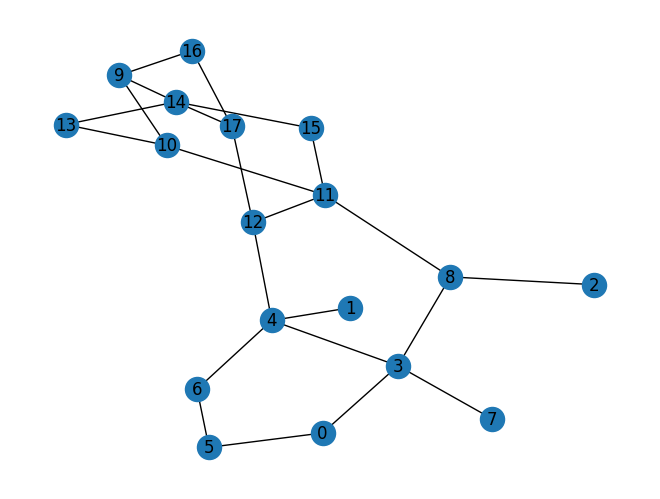

In [62]:
cutval = 1
repval = 1
with open(f'runtime_results/ideal_shot_varying_simulations/ideal-sim_18-nodes_2community_{cutval}-cuts_03-29-2023_{repval}.qpy', 'rb') as fd:
    circuit = qpy.load(fd)[0]
with open(f'runtime_results/ideal_shot_varying_simulations/ideal-sim_18-nodes_2community_{cutval}-cuts_2000-shots_03-29-2023_{repval}.json', 'r') as jf:
    data = json.load(jf)
print(data.keys())
target_graph = data['graphfile']
subgraph_dict = data['subgraph_dict']
cut_nodes = data['cut_nodes']
hot_nodes = data['hot_nodes']
active_mixers = data['active_mixers']
G = qcopt.graph_funcs.graph_from_file(target_graph)
nx.draw_spring(G, with_labels=True)

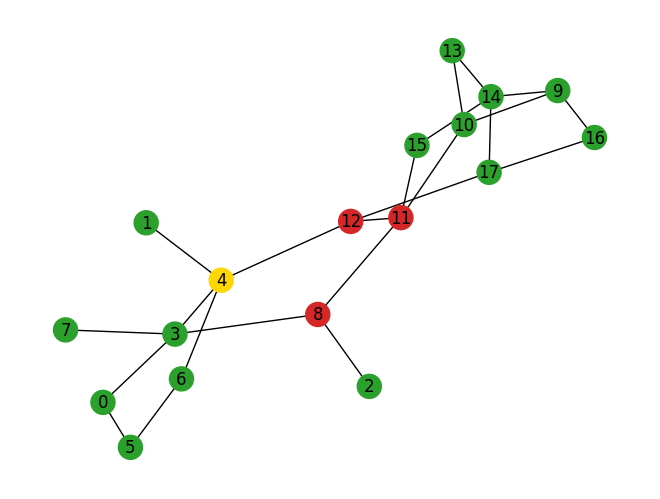

In [59]:
node_color = ['tab:green' if node in active_mixers else 'tab:red' for node in sorted(G.nodes)]
for node in hot_nodes:
    node_color[node] = 'gold'
nx.draw_spring(G, with_labels=True, node_color=[node_color[node] for node in G.nodes])

In [63]:
circuit.draw(fold=-1)

┌─────────┐   ┌──────────────────────────┐   ┌─────────┐                                 ┌───┐         ┌──────────┐                                   ┌───┐         ┌─────────┐                           ┌───┐  ┌──────────┐  ┌───┐┌─────────────────┐┌───────────────────────────┐  ┌─────────┐   ┌───┐  ┌──────────┐ ┌───┐  ┌─────────┐   ┌───┐  ┌──────────┐ ┌───┐┌─────────────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  ┌──────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [65]:
%%capture
subcirc_vertices = get_subcirc_vertices(
    circuit,
    cut_nodes,
    subgraph_dict,
)
cuts = wire_cutting.cut_circuit_wires(
    circuit,
    method='manual',
    subcircuit_vertices=subcirc_vertices,
)

In [71]:
print(cuts['num_cuts'])
print(subgraph_dict)
for qubit, pathmap in cuts['complete_path_map'].items():
    print(qubit)
    pm = []
    print(pathmap)

3
{'9': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0, '0': 1, '1': 1, '2': 1, '3': 1, '4': 1, '5': 1, '6': 1, '7': 1, '8': 1}
Qubit(QuantumRegister(18, 'q'), 0)
[{'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(11, 'q'), 0)}]
Qubit(QuantumRegister(18, 'q'), 1)
[{'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(11, 'q'), 1)}]
Qubit(QuantumRegister(18, 'q'), 2)
[{'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(11, 'q'), 2)}]
Qubit(QuantumRegister(18, 'q'), 3)
[{'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(11, 'q'), 3)}]
Qubit(QuantumRegister(18, 'q'), 4)
[{'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(11, 'q'), 4)}, {'subcircuit_idx': 0, 'subcircuit_qubit': Qubit(QuantumRegister(10, 'q'), 0)}, {'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(11, 'q'), 5)}]
Qubit(QuantumRegister(18, 'q'), 5)
[{'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(11, 'q'), 6)

In [113]:
new_circ, new_subgdict, new_cut_nodes, new_hot_nodes, new_active_mixers = runtime_helpers.get_circuit_from_graph(
    G,
    data['max_cuts'],
    data['params'],
    barriers=0,
    decompose_level=2,
)
new_subgdict = {str(key): val for key, val in new_subgdict.items()}

In [114]:
print(new_subgdict)
print(subgraph_dict)
print(new_subgdict == subgraph_dict)

{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 1, '10': 1, '11': 1, '12': 1, '13': 1, '14': 1, '15': 1, '16': 1, '17': 1}
{'9': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0, '0': 1, '1': 1, '2': 1, '3': 1, '4': 1, '5': 1, '6': 1, '7': 1, '8': 1}
False


In [115]:
print(new_cut_nodes)
print(cut_nodes)

[8, 11, 4, 12]
[8, 11, 4, 12]


In [116]:
print(new_hot_nodes)
print(hot_nodes)

[4]
[4]


In [117]:
%%capture
subcirc_vertices = get_subcirc_vertices(
    new_circ,
    new_cut_nodes,
    new_subgdict,
)
cuts = wire_cutting.cut_circuit_wires(
    new_circ,
    method='manual',
    subcircuit_vertices=subcirc_vertices,
)

In [118]:
cuts['num_cuts']

1

In [119]:
print(new_circ.count_ops())
opt_circ = qiskit.compiler.transpile(new_circ, optimization_level=3)
print(opt_circ.count_ops())

OrderedDict([('u1', 390), ('cx', 378), ('u3', 192), ('u2', 192)])
OrderedDict([('cx', 375), ('u3', 242), ('u1', 190), ('unitary', 1)])


In [120]:
%%capture
subcirc_vertices = get_subcirc_vertices(
    opt_circ,
    new_cut_nodes,
    new_subgdict,
)
cuts = wire_cutting.cut_circuit_wires(
    opt_circ,
    method='manual',
    subcircuit_vertices=subcirc_vertices,
)

In [121]:
cuts['num_cuts']

1

## Gate counts for `ibm_algiers` circuits

In [3]:
algiers_service = QiskitRuntimeService(
    channel="ibm_cloud",
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/37803d76ada74566b6f0114bd5964846:d9a0fc42-0d7f-4bbf-9320-dff97f3c8ed8::"
)
print(algiers_service.backends())
print(algiers_service.programs())

[<IBMBackend('ibm_algiers')>, <IBMBackend('ibm_canberra')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_statevector')>]
[<RuntimeProgram('hello-world')>, <RuntimeProgram('sampler')>, <RuntimeProgram('estimator')>]


In [4]:
algiers_backend = algiers_service.get_backend("ibm_algiers")

In [5]:
config = algiers_backend.configuration()

In [6]:
print("This backend is called {0}, and is on version {1}. It has {2} qubit{3}. It "
      "{4} OpenPulse programs. The basis gates supported on this device are {5}."
      "".format(config.backend_name,
                config.backend_version,
                config.n_qubits,
                '' if config.n_qubits == 1 else 's',
                'supports' if config.open_pulse else 'does not support',
                config.basis_gates))

This backend is called ibm_algiers, and is on version 1.5.11. It has 27 qubits. It supports OpenPulse programs. The basis gates supported on this device are ['cx', 'id', 'rz', 'sx', 'x'].


In [7]:
# full circuit evaluation
with open('runtime_results/QDCA-8qubit-results/algiers-qpu_fullcirc_4000-shots_03-27-2023.pickle', 'rb') as pf:
    fulldata = pickle.load(pf)
fulldata.keys()

dict_keys(['graphfile', 'G', 'params', 'circuit', 'compiled_circuit', 'job_id', 'job_result', 'nearest_distribution', 'full_dist'])

In [13]:
ogcircuit = fulldata['circuit']
compcircuit = fulldata['compiled_circuit']
print(f'Full circuit gate counts:\n\t{compcircuit.count_ops()}\nWith {compcircuit.num_qubits} qubits and {compcircuit.depth()} depth.')

Full circuit gate counts:
	OrderedDict([('rz', 224), ('cx', 176), ('sx', 94), ('x', 26), ('measure', 8), ('barrier', 1)])
With 27 qubits and 335 depth.


In [16]:
#compcircuit.draw(fold=-1)

In [18]:
with open('runtime_results/QDCA-8qubit-results/algiers-qpu_1cuts_2000-shots_03-27-2023.pickle', 'rb') as pf:
    cutdata = pickle.load(pf)
cutdata.keys()

dict_keys(['graphfile', 'G', 'max_cuts', 'params', 'circuit', 'subgraph_dict', 'cut_nodes', 'hot_nodes', 'active_mixers', 'reconstructed_probs', 'cuts', 'metrics', 'recon_dist'])

In [25]:
%%capture
subcirc_vertices = get_subcirc_vertices(
    cutdata['circuit'],
    cutdata['cut_nodes'],
    {str(key): val for key, val in cutdata['subgraph_dict'].items()},
)
cuts = wire_cutting.cut_circuit_wires(
    cutdata['circuit'],
    method='manual',
    subcircuit_vertices=subcirc_vertices,
)

In [28]:
cuts['num_cuts']

1

In [31]:
cuts['subcircuits'][0].draw(fold=-1)

┌─────────┐ ┌──────────────────────────┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────────────┐┌───────────────────────────┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────────────┐                                                                                                                                                                                                                                                                                                                                                                           ┌─────────┐                                                                                                                              ┌───────────┐┌──────────────────────┐
q_0: ─┤ U1(π/2) ├─┤ U3(1.57094103234579,0,0) ├┤ U2(0,π) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U3(π/2,0,-3π/4) ├┤ U3(-1.57094103234579,0,0) ├┤ U2(0,π) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U3(π/2,π/2,π/4) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■────────────────────────────────■───────────■──────────────────┤ U1(π/2) ├──────────────■────────────────────────■────────────────────────────────■────────────■─────────────────────────────────────■──┤ U3(π,0,π) ├┤ U1(3.16658688134399) ├
      ├─────────┤ ├──────────────────────────┤├─────────┤└─┬─┘└──────────┘└─┬─┘└─────────┘└─┬─┘└──────────┘└─┬─┘└─────────────────┘└───────────────────────────┘└─────────┘└─┬─┘└──────────┘└─┬─┘└─────────┘└─┬─┘└──────────┘└─┬─┘└─────────────────┘                 ┌───┐┌──────────┐┌───┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────────────┐┌───────────────────────────┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────────────┐                                                                                              │                  ┌─────────┐   │         ┌─┴─┐                ├─────────┴┐           ┌─┴─┐                      │                  ┌─────────┐   │          ┌─┴─┐               ┌──────────┐      ┌─┴─┐├───────────┤├──────────────────────┤
q_1: ─┤ U1(π/2) ├─┤ U3(4.71213387630102,0,0) ├┤ U2(0,π) ├──┼────────────────┼───────────────┼────────────────┼───────────────────────────────────────────────────────────────┼────────────────┼───────────────┼────────────────┼──────────────────────────────────────┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U3(π/2,0,-3π/4) ├┤ U3(-4.71213387630102,0,0) ├┤ U2(0,π) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U3(π/2,π/2,π/4) ├─────────────────────────────────────────────────────────────────────────────■────────────────┼───────────────■──┤ U1(π/4) ├───┼─────────┤ X ├────────────────┤ U1(-π/4) ├───────────┤ X ├─────■────────────────┼───────────────■──┤ U1(π/4) ├───┼──────────┤ X ├───────────────┤ U1(-π/4) ├──────┤ X ├┤ U3(π,0,π) ├┤ U1(3.16658688134399) ├
     ┌┴─────────┴┐└──────────────────────────┘└─────────┘  │                │               │                │                               ┌───────┐                       │                │               │                │                                      └─┬─┘└──────────┘└─┬─┘└─────────┘└─┬─┘└──────────┘└─┬─┘└─────────────────┘└───────────────────────────┘└─────────┘└─┬─┘└──────────┘└─┬─┘└─────────┘└─┬─┘└──────────┘└─┬─┘└─────────────────┘                   ┌──────────────┐ ┌──────────────────────────┐┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐┌─────────┐┌─┴─┐├─────────┴┐┌─┴─┐┌──────┴───┴──────┐┌────────┴──────────┴───────┐┌──┴───┴──┐┌─┴─┐┌──────────┐┌─┴─┐┌─────────┐┌─┴─┐├─────────┴┐┌─┴─┐┌───────┴───┴────────┐┌─────┴──────────┴─────┐└───┘└───────────┘└──────────────────────┘
q_2: ┤ U3(π,0,π) ├─────────────────────────────────────────┼────────────────■──────────────

In [33]:
subcirc0 = qiskit.compiler.transpile(cuts['subcircuits'][0], backend=algiers_backend, optimization_level=3)
print(f'Subcirc circuit gate counts:\n\t{subcirc0.count_ops()}\nWith {subcirc0.num_qubits} qubits and {subcirc0.depth()} depth.')

Subcirc circuit gate counts:
	OrderedDict([('rz', 74), ('cx', 66), ('sx', 33), ('x', 8)])
With 27 qubits and 124 depth.


In [34]:
cuts['subcircuits'][1].draw(fold=-1)

┌─────────────┐                                                                                                                                                                                                                                                                                                                  ┌───────────┐  ┌──────────────────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
q_0: ──────────────────────────────────────────────────■──────────────────────■─────────────────────────■────────────────────────────────────────■──────────────────────────────────────────────────────────────────■─────────────────────────────────────────────────────────────────────────────────■──┤ U3(0,0,π/8) ├──■─────────────────────────────────────────────────────■─────────────────────────■────────────────────────────────────────■──────────────────────────────────────────────────────────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────────────■────┤ U3(π,0,π) ├──┤ U1(3.16658688134399) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       ┌─────────┐   ┌──────────────────────────────┐  │  ┌────────────────┐  │                         │                                        │  ┌───┐┌──────────────┐┌───┐┌─────────────┐┌───┐┌──────────────┐┌─┴─┐┌─────────────┐┌───┐┌──────────────┐┌───┐┌─────────────┐┌───┐┌──────────────┐┌─┴─┐└─┬─────────┬─┘  │  ┌─────────────────────────────┐┌────────────────┐  │                         │                                        │  ┌───┐┌──────────────┐┌───┐┌─────────────┐┌───┐┌──────────────┐┌─┴─┐┌─────────────┐┌───┐┌──────────────┐┌───┐┌─────────────┐                             ┌───┐┌──────────────┐┌─┴─┐┌─┴───────────┴─┐└──────────────────────┘                                                                  ┌──────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                ┌───┐                ┌──────────┐           ┌───┐                                         ┌─────────┐              ┌───┐               ┌──────────┐      ┌───┐┌─────

In [35]:
subcirc1 = qiskit.compiler.transpile(cuts['subcircuits'][1], backend=algiers_backend, optimization_level=3)
print(f'Subcirc circuit gate counts:\n\t{subcirc1.count_ops()}\nWith {subcirc1.num_qubits} qubits and {subcirc1.depth()} depth.')

Subcirc circuit gate counts:
	OrderedDict([('rz', 127), ('cx', 102), ('sx', 52), ('x', 10)])
With 27 qubits and 215 depth.
